# L11 Advanced CNN[ResidualNet]

In [5]:
import torch
import numpy as np

BATCH_SIZE = 64

In [6]:
# data
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, )) ])
train_dataset = datasets.MNIST(root='dataset/mnist', train=True, transform=transform, download=True) 
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataset = datasets.MNIST(root='dataset/mnist', train=False, transform=transform, download=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [7]:
from torch import nn
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.channels = channels
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

  def forward(self, x):
    y = nn.functional.relu(self.conv1(x))
    y = self.conv2(y)
    return nn.functional.relu(x+y)

In [8]:
# model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv = torch.nn.ModuleList()
    self.rb = torch.nn.ModuleList()
    self.fc = torch.nn.ModuleList()
    
    self.conv.append(torch.nn.Conv2d(1, 16, kernel_size=5))
    self.conv.append(torch.nn.Conv2d(16, 32, kernel_size=5))
    self.rb.append(ResidualBlock(16))
    self.rb.append(ResidualBlock(32))
    self.fc.append(torch.nn.Linear(512, 320)) # in_dim, out_dim;
    self.fc.append(torch.nn.Linear(320, 10))
  
  def forward(self, x):
    in_size = x.size(0) # get N from (N,1,28,28)
    fc_size = len(self.fc)
    
    for i, layer in enumerate(self.conv):
      x = layer(x)
      x = nn.functional.avg_pool2d(x, 2)
      x = nn.functional.relu(x) # first relu then pooling is also ok
      x = self.rb[i](x)
    x = x.view(in_size, -1) # flatten
    for layer_index in range(fc_size-1): # last layer donot need RELU activate
      x = torch.relu(self.fc[layer_index](x))
    return self.fc[fc_size-1](x)
    
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device) # move to GPU
print(device)

cuda:0


In [9]:
# criterion
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

In [10]:
# train
def train(epoch):
  running_loss = 0
  for batch_i, (x, y) in enumerate(train_loader):
    x, y = x.to(device), y.to(device) # move to GPU
    y_hat = net(x)
    loss = criterion(y_hat, y.long()) # torch.Tensor() is float, torch.LongTensor() is num; in this case, .long() removed is ok
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    running_loss += loss.item()
      
  if(running_loss <= 1e-5 or epoch >= 10):
    return True, epoch, running_loss / BATCH_SIZE
  else:
    epoch += 1
    return False, epoch, running_loss / BATCH_SIZE

In [11]:
# test
def test():
  correct = 0
  total = 0
  with torch.no_grad():
    for (x, y) in test_loader:
      x, y = x.to(device), y.to(device) # move to GPU
      y_hat = net(x)
      value, pred_index = torch.max(y_hat.data, dim=1)
      total += y.size(0)
      correct += (pred_index == y).sum().item()
  return correct / total

In [12]:
# epoch
epoch = 0
loss = []
accurate_rate = []

while True:
  train_over, epoch, epoch_loss = train(epoch) 
  loss.append(epoch_loss)
  acc = test()
  accurate_rate.append(acc)
  
  if(train_over):
    break

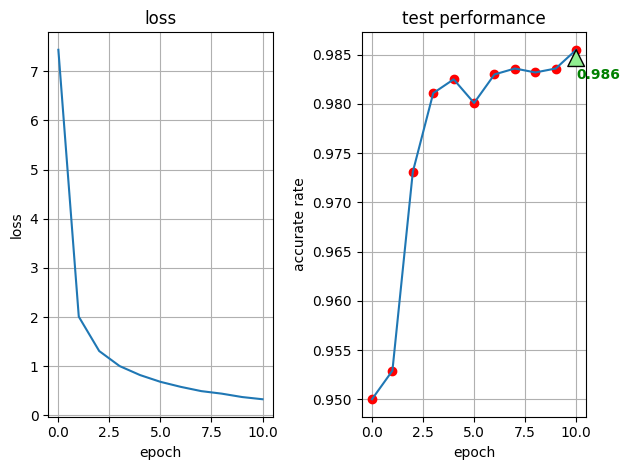

In [13]:
# plot
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title("loss")
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)

plt.subplot(122)
plt.title("test performance")
plt.plot(accurate_rate, "ro")
plt.plot(accurate_rate)
plt.xlabel("epoch")
plt.ylabel("accurate rate")
plt.grid(True)
px, py = 10, accurate_rate[-1]
# plt.text(px-0.2, py-0.002, "%0.3f"%(accurate_rate[-1]), rotation=-30, color='gray')
plt.annotate("%0.3f"%(accurate_rate[-1]), xy=(px, py), xytext=(px,py-0.003),
             color="green", weight="heavy", fontsize=10,
             arrowprops={"facecolor": "lightgreen"})

plt.tight_layout()
# plt.savefig("image/L10_performance.png")
plt.show()